In [1]:
from difflib import SequenceMatcher
import numpy as np
from scipy.optimize import minimize_scalar
from scipy import stats
from Bio.Seq import Seq
import Bio.motifs as bmotifs
import pyProBound
from tqdm import tqdm

import json
import pandas as pd

In [2]:
pfm_file = "../kmer/H12CORE_pfms.txt"
pseudocounts = 0.01

pfm_database = {}  # motif : pfm
with open(pfm_file) as handle:
    for m in bmotifs.parse(handle, "pfm-four-columns"):
        mname = m.name.split("_")[0]
        #.pseudocounts = pseudocounts
        pfm_database[mname] = m#pssm  bbbbb
pfm_database

{'AHR.H12CORE.0.P.B': <Bio.motifs.Motif at 0x7fa6c4354ca0>,
 'AHRR.H12CORE.0.P.C': <Bio.motifs.Motif at 0x7fa6c4354f70>,
 'ALX1.H12CORE.0.SM.B': <Bio.motifs.Motif at 0x7fa6c4365af0>,
 'ALX3.H12CORE.0.SM.B': <Bio.motifs.Motif at 0x7fa6c4365160>,
 'ALX3.H12CORE.1.S.B': <Bio.motifs.Motif at 0x7fa654025520>,
 'ALX4.H12CORE.0.S.B': <Bio.motifs.Motif at 0x7fa6540250a0>,
 'ALX4.H12CORE.1.SM.B': <Bio.motifs.Motif at 0x7fa6540259d0>,
 'ANDR.H12CORE.0.P.B': <Bio.motifs.Motif at 0x7fa654025a30>,
 'ANDR.H12CORE.1.S.C': <Bio.motifs.Motif at 0x7fa654025b50>,
 'ANDR.H12CORE.2.P.B': <Bio.motifs.Motif at 0x7fa654025bb0>,
 'AP2A.H12CORE.0.PSM.A': <Bio.motifs.Motif at 0x7fa654025c10>,
 'AP2B.H12CORE.0.SM.B': <Bio.motifs.Motif at 0x7fa654025c70>,
 'AP2C.H12CORE.0.PSM.A': <Bio.motifs.Motif at 0x7fa654025cd0>,
 'AP2E.H12CORE.0.SM.B': <Bio.motifs.Motif at 0x7fa654025d30>,
 'ARGFX.H12CORE.0.SM.B': <Bio.motifs.Motif at 0x7fa654025d90>,
 'ARI1A.H12CORE.0.P.C': <Bio.motifs.Motif at 0x7fa654025df0>,
 'ARNT.H12COR

In [3]:
hoco_json = 'H12CORE_annotation.jsonl'
hoco_full = pd.read_json(path_or_buf=hoco_json, lines=True)



for key in ['tfclass_superclass', 'tfclass_class', 'tfclass_family']:
    hoco_full[key] = hoco_full['masterlist_info'].apply(lambda x: x[key])
    
hoco_full['species_seen_in'] = hoco_full['masterlist_info'].apply(lambda x: x["species"].keys())
hoco_full['original_species'] = hoco_full['original_motif'].apply(lambda x: x["species"])

columns = ['name', 'tfclass_superclass', 
           'tfclass_class', 'tfclass_family', 'species_seen_in', 'original_species', 'pfm']
hoco_full = hoco_full[columns]

<Axes: xlabel='original_species', ylabel='tfclass_superclass'>

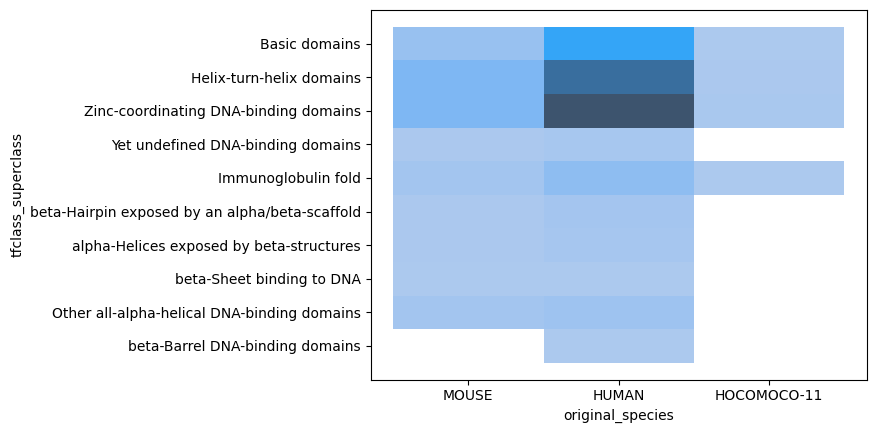

In [4]:
import seaborn as sns
sns.histplot(data=hoco_full, x='original_species', y='tfclass_superclass')

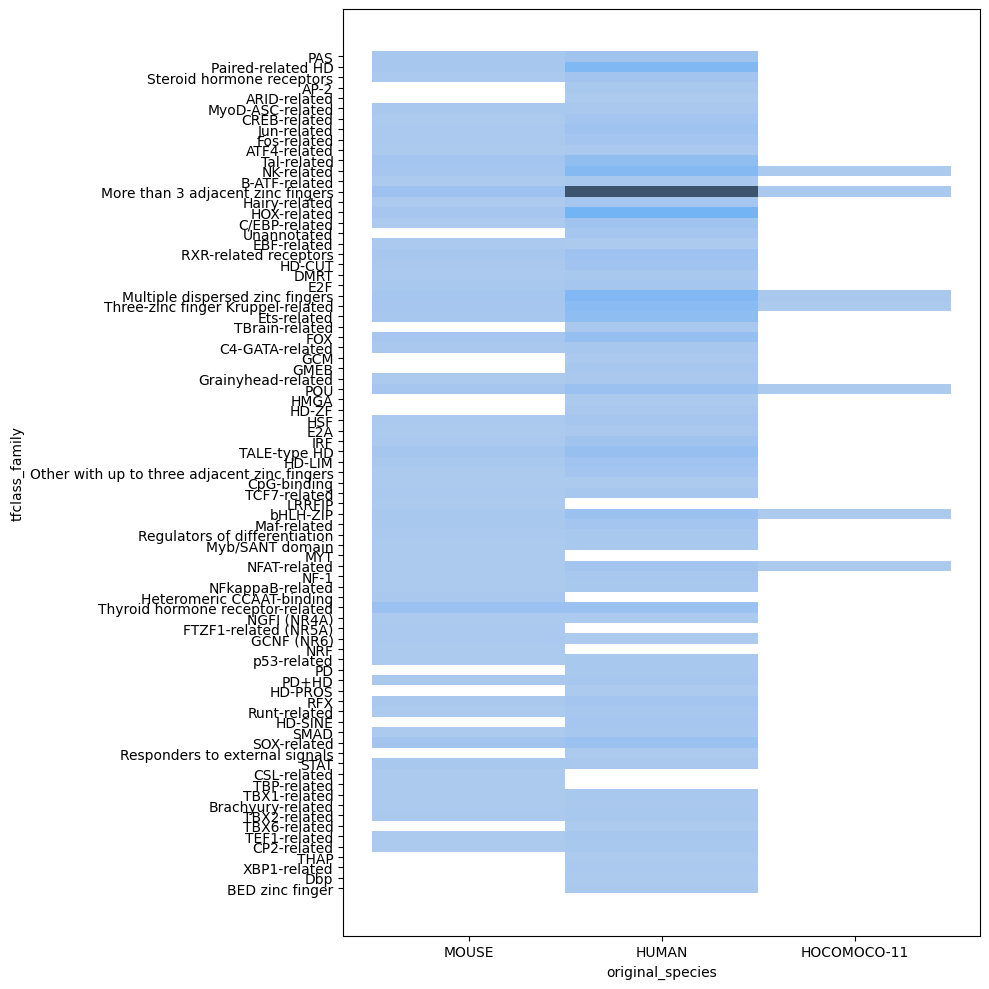

In [5]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.histplot(data=hoco_full, x='original_species', y='tfclass_family')

plt.tight_layout()

# Available HOCOMOCO datasets

- for mouse, for human
- all superclasses
- every single superclass
- every tfclass_family

In [19]:
import os

dirpath = '../kmer/sources_for_motif_based_scoring/hocomoco/'
len_thr = 5
with open(os.path.join(dirpath, "datasets.csv"), mode='w') as writer:
    print(f"dataset name,species,grouper,motifs", file=writer)
    
    for species in ['MOUSE', 'HUMAN']:
        # os.makedirs(os.path.join(dirpath, species), exist_ok=True)
        dataset = hoco_full[hoco_full['original_species'] == species]

        # save full
        motifs = ";".join(dataset['name'].values)
        print(f"full,{species},,{motifs}", file=writer)

        for grouper in ['tfclass_family', 'tfclass_class', 'tfclass_superclass']:
            for name, group in dataset.groupby(by=grouper):
                if len(group) >= len_thr:
                    motifs = ";".join(group['name'].values)
                    print(f"{name},{species},{grouper},{motifs}", file=writer)

# ProBound

In [36]:
mc = pyProBound.MotifCentral()
mc = mc.data

dirpath = '../kmer/sources_for_motif_based_scoring/probound/'

for name, group in mc.groupby(by='taxa'):
    models, names = group['model_id'].values.astype(int), group["gene_symbols"].str[0].values
    display(group)
    
    for model_id, name in zip(models, names):   
        model = pyProBound.ProBoundModel(int(model_id), motifcentral=True)
        model.select_binding_mode(0) 
        
        model.write_model(os.path.join(dirpath, f"{model_id}.json"))
        

,model_id,gene_symbols,tax_id,gene_names,publications,studies,taxa
7,10648,[Gsc],7227,Goosecoid,[Nitta2015],[Nitta2015-Gsc_KG_TGTCTA20NTCG],Drosophila melanogaster
25,11210,[ems],7227,empty spiracles,[Nitta2015],[Nitta2015-ems_KD_TTACCA20NCCA],Drosophila melanogaster
26,11212,[bsh],7227,brain-specific homeobox,[Nitta2015],[Nitta2015-bsh_KA_TGCATC20NGA],Drosophila melanogaster
27,11213,[bcd],7227,bicoid,[Nitta2015],[Nitta2015-bcd_KD_TTGCCG20NTA],Drosophila melanogaster
28,11215,[Dll],7227,Distal-less,[Nitta2015],[Nitta2015-Dll_KI_TTCTGA20NGTC],Drosophila melanogaster
...,...,...,...,...,...,...,...
516,16357,[nub],7227,nubbin,[Nitta2015],[Nitta2015-nub_KI_TGACTC20NTCA],Drosophila melanogaster
517,16379,[CG4360],7227,uncharacterized protein,[Nitta2015],[Nitta2015-CG4360_KM_TGCAGC40NATT],Drosophila melanogaster
518,16388,[Aef1],7227,Adult enhancer factor 1,[Nitta2015],[Nitta2015-Aef1_KY_TCGAGT40NACT],Drosophila melanogaster
519,16392,[sna],7227,snail,[Nitta2015],[Nitta2015-sna_KY_TGGCCT40NTAT],Drosophila melanogaster


https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/10648
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11210
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11212
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11213
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11215
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11217
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11218
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11219
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11227
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11232
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11388
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11436
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11477
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11548
https://prod-gateway

https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/15319
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/15323
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/15324
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/15328
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/15329
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/15330
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/15333
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/15334
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/15335
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/15336
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/15338
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/15340
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/15341
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/15342
https://prod-gateway

,model_id,gene_symbols,tax_id,gene_names,publications,studies,taxa
2,10592,[EGR1],9606,early growth response 1,[Yang2017],[Yang2017-EGR1_ESY_TCTCTT20NGA],Homo sapiens
3,10594,[RXRA],9606,retinoid X receptor alpha,[Yang2017],[Yang2017-RXRA_ESAI_TCTACA40NCAG],Homo sapiens
4,10629,[SOX17],9606,SRY-box transcription factor 17,[Isakova2017],[Isakova2017-SOX17],Homo sapiens
8,10649,[RARG],9606,retinoic acid receptor gamma,[Yang2017],[Yang2017-RARG_ESY_TGTTAT20NGA],Homo sapiens
11,10662,[MAFB],9606,MAF bZIP transcription factor B,[Rodriguez2017],[Rodriguez2017-MAFB_20N],Homo sapiens
...,...,...,...,...,...,...,...
869,19235,[RFX2],9606,regulatory factor X2,"[Yang2017, Jolma2013, Yin2017]","[Yang2017-RFX2_ESY_TAACCC20NCCA, Jolma2013-RFX...",Homo sapiens
870,19242,[SCRT2],9606,scratch family transcriptional repressor 2,"[Yang2017, Yin2017]","[Yang2017-SCRT2_ESY_TGGGCG20NCGT, Yin2017-SCRT...",Homo sapiens
871,19243,[SHOX],9606,short stature homeobox,"[Yang2017, Jolma2013, Yin2017]","[Yang2017-SHOX_ESAC_TAAGGT20NGGA, Jolma2013-SH...",Homo sapiens
872,19254,[TEAD1],9606,TEA domain transcription factor 1,"[Yang2017, Jolma2013, Yin2017]","[Yang2017-TEAD1_ESW_TCTTAG20NATG, Jolma2013-TE...",Homo sapiens


https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/10592
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/10594
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/10629
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/10649
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/10662
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/10676
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/10752
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/10753
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/10759
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11168
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11192
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11197
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11200
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11226
https://prod-gateway

https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/13998
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/14001
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/14031
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/14045
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/14073
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/14099
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/14108
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/14109
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/14132
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/14276
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/14479
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/14487
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/15020
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/15021
https://prod-gateway

https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/16239
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/16255
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/16264
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/16273
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/16278
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/16400
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/16401
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/16413
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/16426
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/16638
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/16640
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/16643
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/16647
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/16652
https://prod-gateway

https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17095
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17097
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17100
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17102
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17103
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17104
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17105
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17107
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17109
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17111
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17112
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17113
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17114
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17116
https://prod-gateway

https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17786
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17789
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17794
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17845
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17865
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17870
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17891
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17899
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17904
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17963
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17965
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17970
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17976
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/17977
https://prod-gateway

https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/19242
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/19243
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/19254
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/19293


,model_id,gene_symbols,tax_id,gene_names,publications,studies,taxa
0,10109,[Tfe3],10090,transcription factor E3,[Isakova2017],[Isakova2017-TFE3_mouse],Mus musculus
1,10589,[Gata3],10090,GATA binding protein 3,[Isakova2017],[Isakova2017-GATA3_mouse],Mus musculus
5,10637,[Sp4],10090,trans-acting transcription factor 4,[Isakova2017],[Isakova2017-SP4],Mus musculus
6,10644,[Rarg],10090,"retinoic acid receptor, gamma",[Yang2017],[Yang2017-Rarg_ESZ_TATCTG20NTCG],Mus musculus
9,10653,[Vsx1],10090,visual system homeobox 1,[Jolma2013],[Jolma2013-Vsx1_ESP_TGCAGA20NCG],Mus musculus
...,...,...,...,...,...,...,...
485,16105,[Hoxd9],10090,homeobox D9,[Yang2017],[Yang2017-Hoxd9_ESZ_TCCTAA20NCG],Mus musculus
486,16123,[Klf12],10090,Kruppel-like factor 12,[Yang2017],[Yang2017-Klf12_ESZ_TGATGG20NGA],Mus musculus
488,16133,[Meox2],10090,mesenchyme homeobox 2,[Yang2017],[Yang2017-Meox2_ESZ_TACGTC20NTGC],Mus musculus
493,16209,[Sox3],10090,SRY (sex determining region Y)-box 3,[Yang2017],[Yang2017-Sox3_ESQ_TGGGGT20NCG],Mus musculus


https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/10109
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/10589
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/10637
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/10644
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/10653
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/10654
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/10780
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11166
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11179
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11184
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11190
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11237
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11262
https://prod-gateway.motifcentral.org/cellx/api/web/utility/fit/11323
https://prod-gateway

In [34]:
pyProBound.ProBoundModel(f"{model_id}.json", fitjson=True)